# Discrete examples

In [335]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, time
sys.path.insert(1, '../discrete_mixflows/')
from discrete_mixflows import *
from gibbs import *
from concrete import *

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

## 1D toy example

First we generate a one-dimensional synthetic example
where $\pi$ is a distribution over $\{1,\dots,10\}$.
We approximate $\pi$ with a MAD Mix $q_N$
of depth $N=500$ and with a uniform reference 
$q_0\sim\mathsf{U}\{1,\dots10\}$.
We also target $\pi$ with a standard Gibbs sampler
run for 50,000 iterations, where only the last 500 are kept.

Below we show a plot of the exact density $q_N(x)$ compared to $\pi(x)$,
along with a histogram of samples from the Gibbs sampler.

In [257]:
########################
########################
# target specification #
########################
########################
np.random.seed(2023)
K1=10
prbs=np.random.rand(K1)
prbs=prbs/np.sum(prbs)
def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs
    #
    # inputs:
    #    x    : (1,d) array with state values
    #    axis : int, full conditional to calculate; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,K1) array with d conditionals 
    
    ext_lprb=np.log(np.repeat(prbs[:,np.newaxis],x.shape[1],axis=1).T)
    if axis==None: return np.squeeze(ext_lprb[np.arange(0,x.shape[1]),x])
    return ext_lprb

In [258]:
########################
########################
#    MAD Mix approx    #
########################
########################

# reference specification
lq0 = lambda x,u : np.log(1/K1)*np.ones(x.shape[1])
def randq0(size): return np.random.randint(0,K1,size).reshape(1,size),np.random.rand(1,size)

N=500 # number of steps in qN
xi=np.pi/16

# evaluate density
x=np.array(np.arange(0,K1)[np.newaxis,:],dtype=int)
u=np.random.rand(1,K1)
qvar=np.exp(lqN(x,u,N,lq0,lp,xi))

In [259]:
# compute ELBO
elbo_qN=elbo_exact(np.log(qvar/np.sum(qvar)),np.log(prbs))

In [260]:
########################
########################
#    Gibbs sampling    #
########################
########################
np.random.seed(2023)
x0=np.random.randint(low=0,high=K1)*np.ones(1)
gibbs_samples=gibbs_sampler(x0=x0,steps=N,lp=lp,burnin_pct=0.99,verbose=True)

In [261]:
# get density and compute ELBO
gibbs_density=plt.hist(gibbs_samples[0,:],density=True,bins=np.arange(0,K1+1))[0]
plt.clf()
elbo_gibbs=elbo_exact(np.log(gibbs_density),np.log(prbs))

<Figure size 1500x750 with 0 Axes>

In [130]:
########################
########################
#    Concrete          #
########################
########################
from IPython.display import clear_output
RUN=False # ONLY TRUE IF YOU WANT TO RERUN RESULTS

# TIME SUNK!!! RUN AT YOUR OWN PERIL
# simulation settings:
max_iters = 10001
temps     = np.array([0.1,0.5,1,5])
depths    = np.array([10,50,100])
layers    = np.array([32,64,128,256,512])
sim_size  = temps.shape[0]*depths.shape[0]*layers.shape[0]
if RUN:
    # redefine arrays only if running from scratch
    flows     = [0 for i in range(sim_size)]
    losses    = np.zeros((sim_size,max_iters))
    cpu_times = np.zeros(sim_size)

i=0
print('Training '+str(sim_size)+' flows')
for temp in temps:
    if RUN: continue
    for depth in depths:
        for width in layers:
            print('Training flow '+str(i+1)+'/'+str(sim_size))
            print('Temperature: '+str(temp))
            print('Depth: '+str(depth))
            print('Width: '+str(width))
            t0 = time.perf_counter()
            tmp_flow,tmp_loss=trainRealNVP(
                temp=temp,depth=depth,lprbs=np.log(prbs),layers=layer,max_iters=max_iters,lr=1e-3,seed=2023
            )
            cpu_times[i]=time.perf_counter()-t0
            flows[i]=tmp_flow
            losses[i,:]=tmp_loss
            clear_output(wait=True)
            i=i+1
        # end for
    # end for
# end for
clear_output(wait=True)
print('Done!')
print('Total training time: '+str(cpu_times.sum())+' seconds')

Done!
Total training time: 29729.71328941399 seconds


Text(0.5, 1.0, 'Concrete RealNVP training loss traceplots')

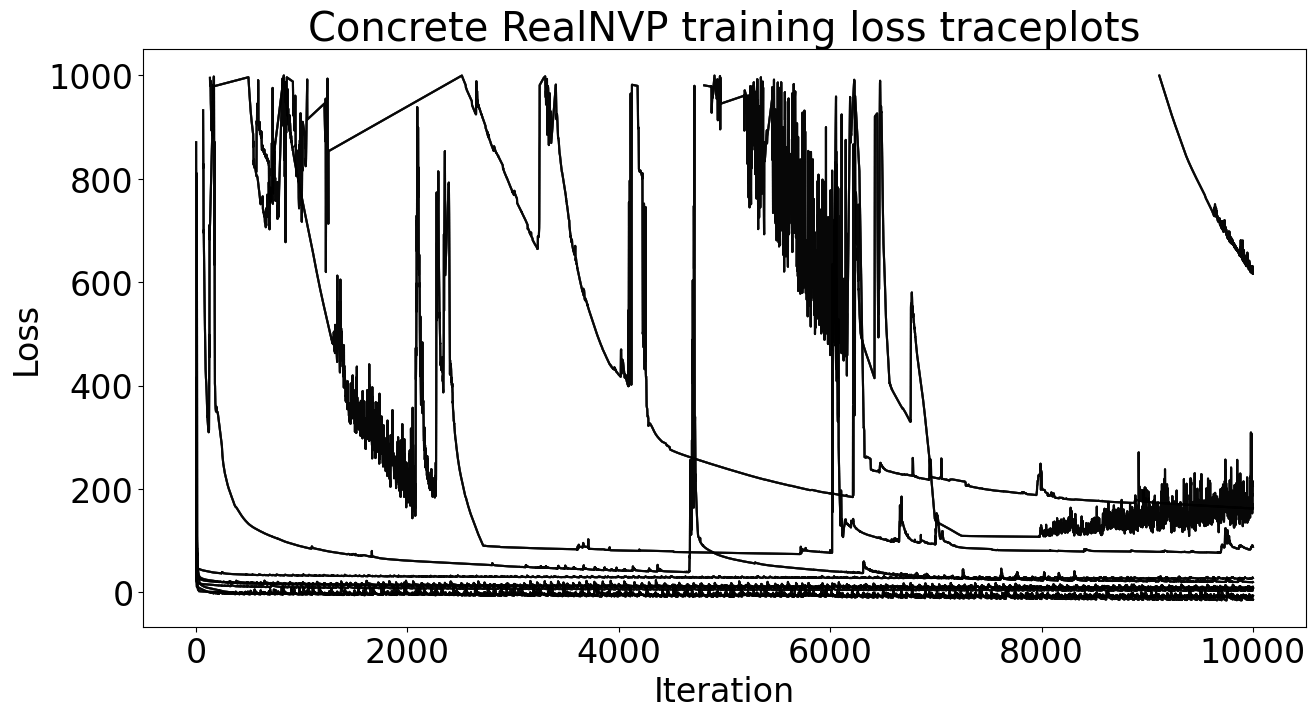

In [262]:
# loss traceplot
threshold=1000
for i in range(sim_size): plt.plot(np.arange(max_iters)[losses[i,:]<threshold],losses[i,losses[i,:]<threshold],'-k',alpha=0.5)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Concrete RealNVP training loss traceplots')

In [318]:
#########################
#########################
# get samples and elbos #
#########################
#########################
torch.manual_seed(1)
sample_size=1000
samples=np.zeros((sim_size,sample_size))
densities=np.zeros((sim_size,K1))
elbos=np.zeros(sim_size)

for i in range(sim_size):
    print(str(i+1)+'/'+str(sim_size),end='\r')
    tmp_flow=flows[i]
    
    # generate sample
    tmp_sample=tmp_flow.sample(sample_size)
    tmp_sample=np.exp(np.squeeze(tmp_sample.detach().numpy())) # expConcrete->Concrete
    tmp_sample=tmp_sample/np.sum(tmp_sample,axis=-1)[:,np.newaxis] # normalize probs
    tmp_sample=np.argmax(tmp_sample,axis=-1) # rounding Concrete
    samples[i,:]=tmp_sample
    
    # compute freq density
    tmp_density=plt.hist(tmp_sample,density=True,bins=np.arange(0,K1+1))[0]
    tmp_density[tmp_density<1e-32]=1e-32 # to avoid underflow when taking log
    densities[i,:]=tmp_density
    
    # estimate elbo
    elbos[i]=elbo_exact(np.log(tmp_density),np.log(prbs))
# end for
plt.clf()

/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_73986/4187937856.py:18: RuntimeWarning: overflow encountered in exp
  tmp_sample=np.exp(np.squeeze(tmp_sample.detach().numpy())) # expConcrete->Concrete
/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_73986/4187937856.py:19: RuntimeWarning: invalid value encountered in divide
  tmp_sample=tmp_sample/np.sum(tmp_sample,axis=-1)[:,np.newaxis] # normalize probs


<Figure size 1500x750 with 0 Axes>

In [320]:
i_star=np.argmax(elbos) #temp=0.5, depth=50, width=64
print('Optimal flow: '+str(i_star))

Optimal flow: 22


In [321]:
print('ELBO(qN||π)='+str(elbo_qN))
print('ELBO(qGibbs||π)='+str(elbo_gibbs))
print('ELBO(qConcrete_opt||π)='+str(elbos[np.argmax(elbos)]))

ELBO(qN||π)=-0.00040329033243014217
ELBO(qGibbs||π)=-0.002063302048339602
ELBO(qConcrete_opt||π)=-0.042395077130970855


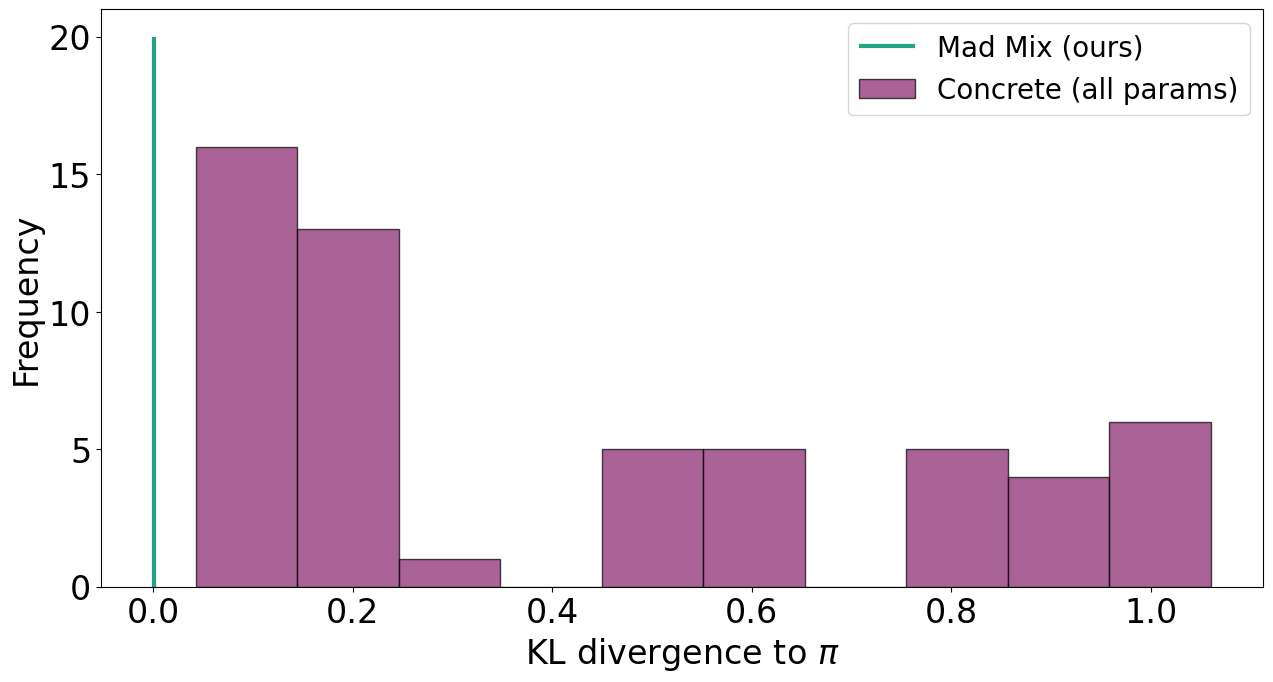

In [322]:
plt.vlines(-elbo_qN,ymin=0,ymax=20,colors='#20A386FF',lw=3,label='Mad Mix (ours)')
#plt.vlines(-elbo_gibbs,ymin=0,ymax=20,colors='#FBB91FFF',lw=1.5,label='Gibbs',alpha=0.8)
plt.hist(-elbos[-elbos<2],bins=15,color='#87216BFF',ec='black',alpha=0.7,label='Concrete (all params)') #taking out elbo<-2
plt.xlabel(r'KL divergence to $\pi$')
plt.ylabel('Frequency')
plt.legend(fontsize='small')

Text(0, 0.5, 'probability')

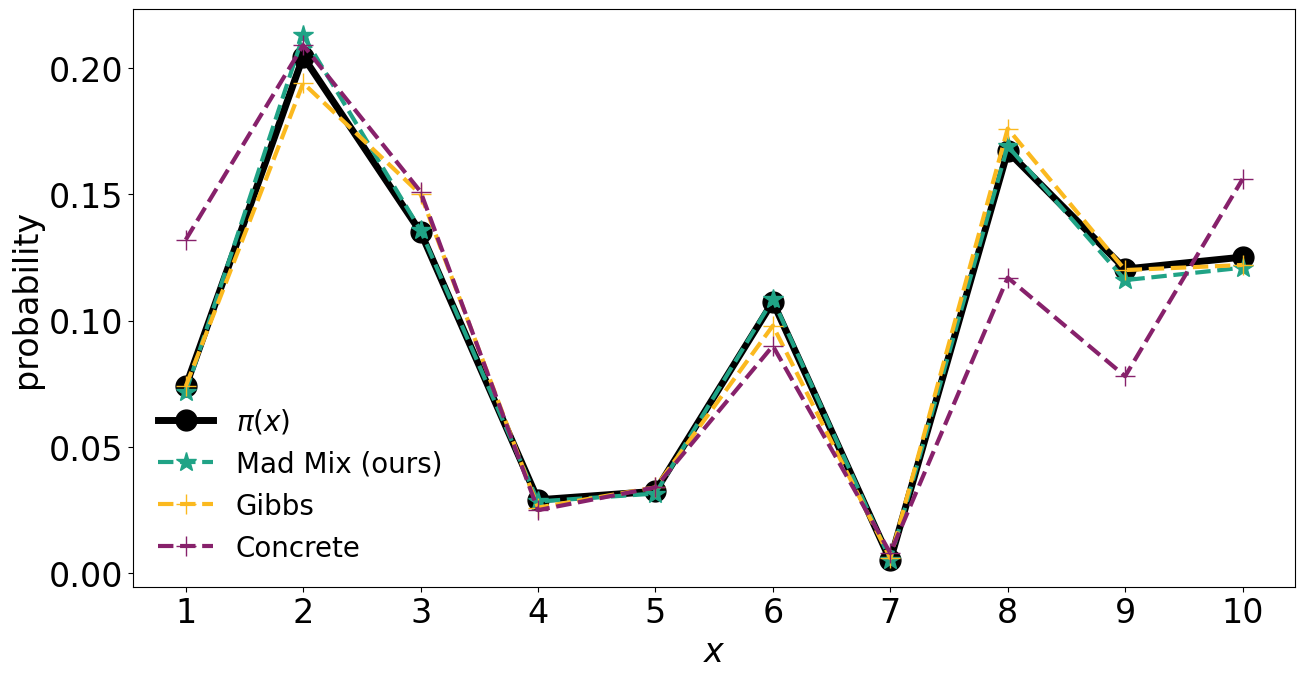

In [323]:
########################
########################
#     plot results     #
########################
########################

ttx=np.arange(0,K1)
plt.plot(ttx+0.5,prbs,c="black", label=r'$\pi(x)$',lw=5,ms=15,marker='o')
plt.plot(ttx+0.5,qvar/np.sum(qvar),c='#20A386FF', label='Mad Mix (ours)',lw=3,ls='dashed',ms=15,marker='*')
plt.plot(ttx+0.5,gibbs_density,c='#FBB91FFF', label='Gibbs',lw=3,ls='dashed',ms=15,marker='+')
plt.plot(ttx+0.5,densities[np.argmax(elbos),:],c='#87216BFF', label='Concrete',lw=3,ls='dashed',ms=15,marker='+')
plt.legend(fontsize='small',frameon=False)
plt.xlabel(r'$x$')
plt.xticks(ticks=np.arange(0,K1)+0.5,labels=np.arange(1,1+K1))
plt.ylabel('probability')

## 2D toy example

Now we generate a two-dimensional synthetic example
where $\pi$ is a distribution over 
$\mathcal{X}=\{1,\dots,4\}\times\{1,\dots,5\}$.
We approximate $\pi$ with a MAD Mix $q_N$
of depth $N=500$ and with a uniform reference 
$q_0\sim\mathsf{U}(\mathcal{X})$.
We also target $\pi$ with a standard Gibbs sampler
run for 50,000 iterations, where only the last 500 are kept.

Below we show plots of the exact marginal densities $q_N(x_m)$ compared to $\pi(x_m)$,
$m=1,2$, along with a corresponding histogram of samples from the Gibbs sampler.

In [548]:
########################
########################
# target specification #
########################
########################
np.random.seed(2023)
K1=4
K2=5
prbs=np.random.rand(K1,K2)
prbs=prbs/np.sum(prbs)
def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs
    #
    # inputs:
    #    x    : (2,d) array with state values
    #    axis : int, full conditional to calculate; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,K_{axis+1}) array with d conditionals 
    
    ext_lprb=np.log(np.moveaxis(np.repeat(prbs[:,:,np.newaxis],x.shape[1],axis=-1),2,0)) # stack d copies of logp vertically
    if axis==None: return np.squeeze(ext_lprb[np.arange(0,x.shape[1]),x[0,:],x[1,:]]) # for each d, return lp(x)
    if axis==0: return ext_lprb[np.arange(0,x.shape[1]),:,x[1,:]]
    if axis==1: return ext_lprb[np.arange(0,x.shape[1]),x[0,:],:]
    raise Exception("Axis out of bounds - there aren't that many variables")

In [549]:
########################
########################
#    MAD Mix approx    #
########################
########################

# reference specification
lq0 = lambda x,u : -np.log(K1*K2)*np.ones(x.shape[1])
def randq0(size): return np.vstack((np.random.randint(0,K1,size),np.random.randint(0,K2,size))).T,np.random.rand(size,size)

N=500 # number of steps in qN
xi=np.pi/16

# evaluate density
# first create a grid of values of x1 and x2
# adapted from https://stackoverflow.com/questions/27286537/numpy-efficient-way-to-generate-combinations-from-given-ranges
x = np.mgrid[0:K1,0:K2] 
x = np.rollaxis(x, 0, 3)
x = x.reshape((K1*K2,2)).T
myx=np.copy(x)
# now sample u and evaluate density
u=np.random.rand(2,K1*K2)
qvar=np.exp(lqN(x,u,N,lq0,lp,xi))
myqvar=qvar.reshape(prbs.shape) # to move back from (K1*K2,) to (K1,K2) array

In [550]:
elbo_qN=elbo_exact(np.log(myqvar/np.sum(myqvar)),np.log(prbs))

In [551]:
########################
########################
#    Gibbs sampling    #
########################
########################
np.random.seed(2023)
x0=np.array([np.random.randint(low=0,high=K1),np.random.randint(low=0,high=K2)])
gibbs_samples=gibbs_sampler(x0=x0,steps=N,lp=lp,burnin_pct=0.99,verbose=True)

In [552]:
# get density and compute ELBO
gibbs_density=plt.hist2d(gibbs_samples[0,:],gibbs_samples[1,:],density=True,
                         bins=[np.arange(0,K1+1),np.arange(0,K2+1)])[0]
plt.clf()
elbo_gibbs=elbo_exact(np.log(gibbs_density),np.log(prbs))

<Figure size 1500x750 with 0 Axes>

In [415]:
########################
########################
#    Concrete          #
########################
########################
from IPython.display import clear_output
RUN=False # ONLY TRUE IF YOU WANT TO RERUN RESULTS

# TIME SUNK!!! RUN AT YOUR OWN PERIL
# simulation settings:
max_iters = 10001
temps     = np.array([0.1,0.5,1,5])
depths    = np.array([10,50,100])
layers    = np.array([32,64,128,256])
sim_size  = temps.shape[0]*depths.shape[0]*layers.shape[0]
if RUN:
    # redefine arrays only if running from scratch
    flows2d     = [0 for i in range(sim_size)]
    losses2d    = np.zeros((sim_size,max_iters))
    cpu_times2d = np.zeros(sim_size)

i=0
print('Training '+str(sim_size)+' flows')
for temp in temps:
    if not RUN: continue
    for depth in depths:
        for width in layers:
            print('Training flow '+str(i+1)+'/'+str(sim_size))
            print('Temperature: '+str(temp))
            print('Depth: '+str(depth))
            print('Width: '+str(width))
            t0 = time.perf_counter()
            tmp_flow,tmp_loss=trainRealNVP(
                temp=temp,depth=depth,lprbs=np.log(prbs).flatten(),layers=layer,max_iters=max_iters,lr=1e-3,seed=2023
            )
            cpu_times2d[i]=time.perf_counter()-t0
            flows2d[i]=tmp_flow
            losses2d[i,:]=tmp_loss
            clear_output(wait=True)
            i=i+1
        # end for
    # end for
# end for
clear_output(wait=True)
print('Done!')
print('Total training time: '+str(cpu_times2d.sum())+' seconds')

Done!
Total training time: 44350.424769626 seconds


Text(0.5, 1.0, 'Concrete RealNVP training loss traceplots')

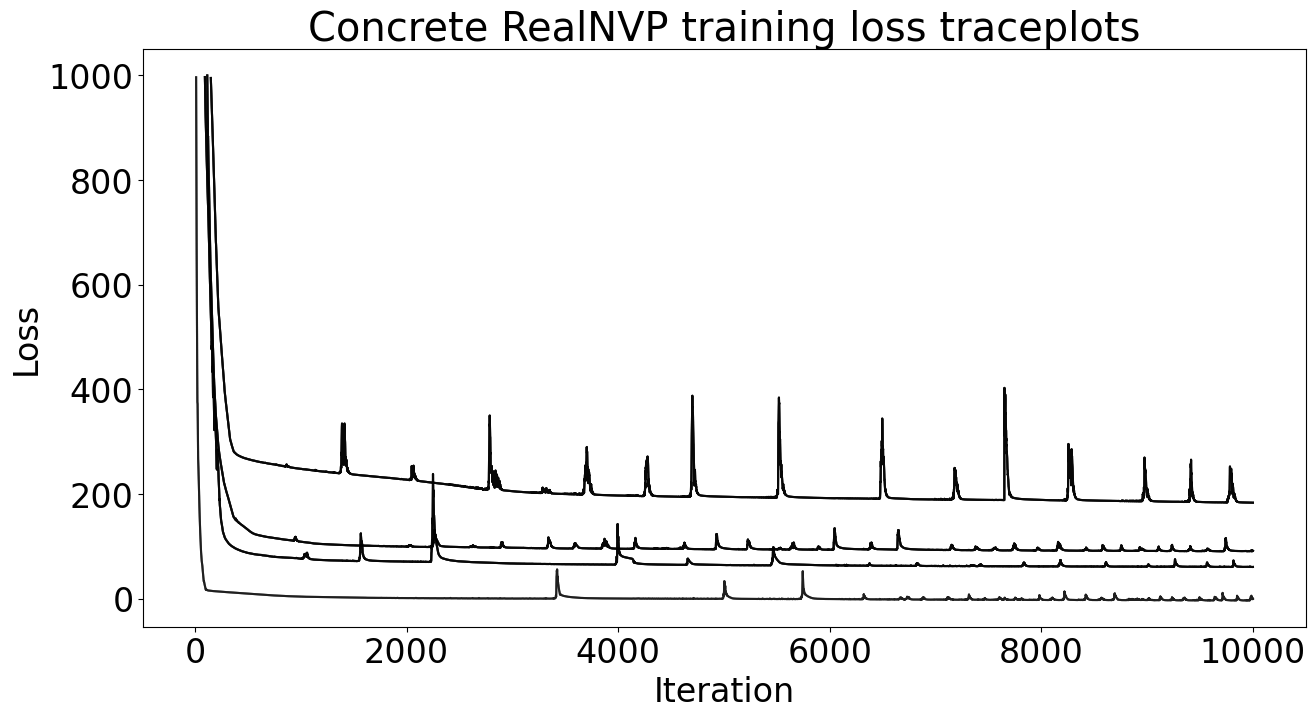

In [539]:
# loss traceplot
threshold=1000
for i in range(sim_size): plt.plot(np.arange(max_iters)[losses2d[i,:]<threshold],losses2d[i,losses2d[i,:]<threshold],'-k',alpha=0.5)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Concrete RealNVP training loss traceplots')

In [417]:
def idx_unflatten(x,K2):
    """
    Each x_i is an integer in [0,K1*K2)
    Converts to tuples in [0,K1]x[0,K2]

    Input:
        x  : (d,) array, flattened array
    Output:
        x_ : (2,d) array, unflattened array
    """
    return np.vstack((x//K2,x%K2))

In [540]:
#########################
#########################
# get samples and elbos #
#########################
#########################
torch.manual_seed(1)
sample_size=1000
samples2d=np.zeros((sim_size,2,sample_size))
densities2d=np.zeros((sim_size,K1,K2))
elbos2d=np.zeros(sim_size)

for i in range(sim_size):
    print(str(i+1)+'/'+str(sim_size),end='\r')
    tmp_flow=flows2d[i]
    
    # generate sample
    tmp_sample=tmp_flow.sample(sample_size)
    tmp_sample=np.exp(np.squeeze(tmp_sample.detach().numpy())) # expConcrete->Concrete
    tmp_sample=tmp_sample/np.sum(tmp_sample,axis=-1)[:,np.newaxis] # normalize probs
    tmp_sample=np.argmax(tmp_sample,axis=-1) # rounding Concrete
    tmp_sample=idx_unflatten(tmp_sample,K2) # 1d->2d
    samples2d[i,:,:]=tmp_sample
    
    # compute freq density
    tmp_density=plt.hist2d(tmp_sample[0,:],tmp_sample[1,:],density=True,
                         bins=[np.arange(0,K1+1),np.arange(0,K2+1)])[0]
    tmp_density[tmp_density<1e-32]=1e-32 # to avoid underflow when taking log
    densities2d[i,:]=tmp_density
    
    # estimate elbo
    elbos2d[i]=elbo_exact(np.log(tmp_density),np.log(prbs))
# end for
plt.clf()

/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_73986/3867707760.py:18: RuntimeWarning: overflow encountered in exp
  tmp_sample=np.exp(np.squeeze(tmp_sample.detach().numpy())) # expConcrete->Concrete
/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_73986/3867707760.py:19: RuntimeWarning: invalid value encountered in divide
  tmp_sample=tmp_sample/np.sum(tmp_sample,axis=-1)[:,np.newaxis] # normalize probs


<Figure size 1500x750 with 0 Axes>

In [541]:
i_star2d=np.argmax(elbos2d) #temp=0.5, depth=50, width=64
print('Optimal flow: '+str(i_star2d))

Optimal flow: 35


In [544]:
print('ELBO(qN||π)='+str(elbo_qN))
print('ELBO(qGibbs||π)='+str(elbo_gibbs))
print('ELBO(qConcrete_opt||π)='+str(elbos2d[np.argmax(elbos2d)]))

ELBO(qN||π)=-0.002000021625141389
ELBO(qGibbs||π)=-0.012151424983941169
ELBO(qConcrete_opt||π)=-1.32553472029383


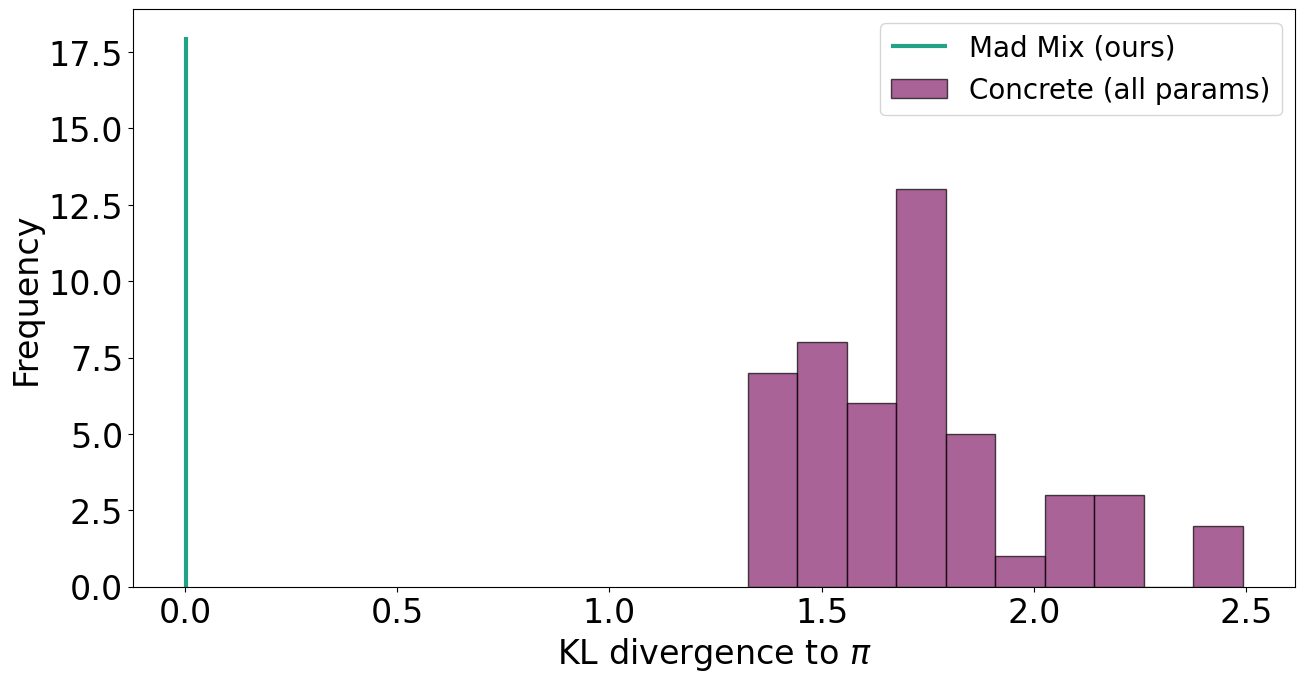

In [545]:
plt.vlines(-elbo_qN,ymin=0,ymax=18,colors='#20A386FF',lw=3,label='Mad Mix (ours)')
#plt.vlines(-elbo_gibbs,ymin=0,ymax=20,colors='#FBB91FFF',lw=1.5,label='Gibbs',alpha=0.8)
plt.hist(-elbos2d,bins=10,color='#87216BFF',ec='black',alpha=0.7,label='Concrete (all params)') #taking out elbo<-2
plt.xlabel(r'KL divergence to $\pi$')
plt.ylabel('Frequency')
plt.legend(fontsize='small')

Text(0, 0.5, 'probability')

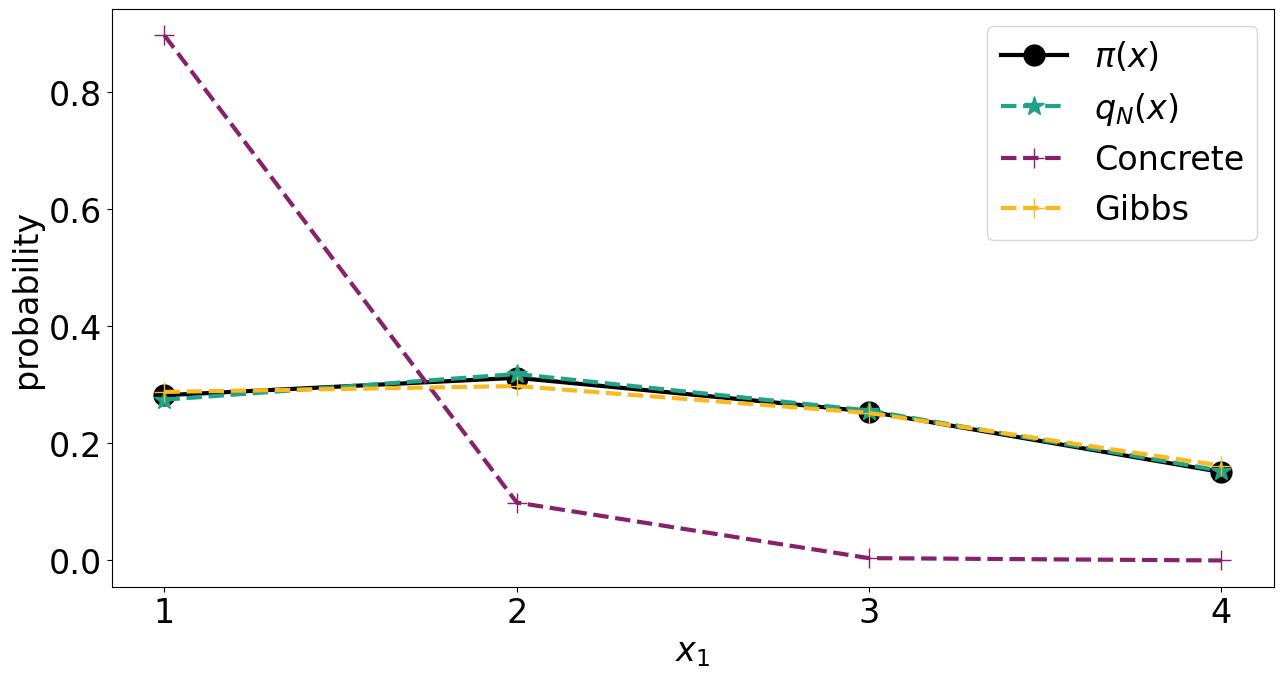

In [546]:
########################
########################
#   plot x1 results    #
########################
########################

ttx=np.arange(0,K1)
plt.plot(ttx+0.5,np.sum(prbs,axis=1),c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.plot(ttx+0.5,np.sum(myqvar,axis=1),c='#20A386FF', label=r'$q_N(x)$',lw=3,ls='dashed',ms=15,marker='*')
plt.plot(ttx+0.5,np.sum(densities2d[np.argmax(elbos2d),:,:],axis=1),c='#87216BFF', label='Concrete',lw=3,ls='dashed',ms=15,marker='+')
#plt.hist(gibbs_samples[0,:],density=True,bins=np.arange(0,K1+1),alpha=0.35, label='Gibbs', color="#FBB91FFF",ec='black')
plt.plot(ttx+0.5,np.sum(gibbs_density,axis=1),c='#FBB91FFF', label='Gibbs',lw=3,ls='dashed',ms=15,marker='+')
plt.legend()
plt.xlabel(r'$x_1$')
plt.xticks(ticks=np.arange(0,K1)+0.5,labels=np.arange(1,1+K1))
plt.ylabel('probability')

Text(0, 0.5, 'probability')

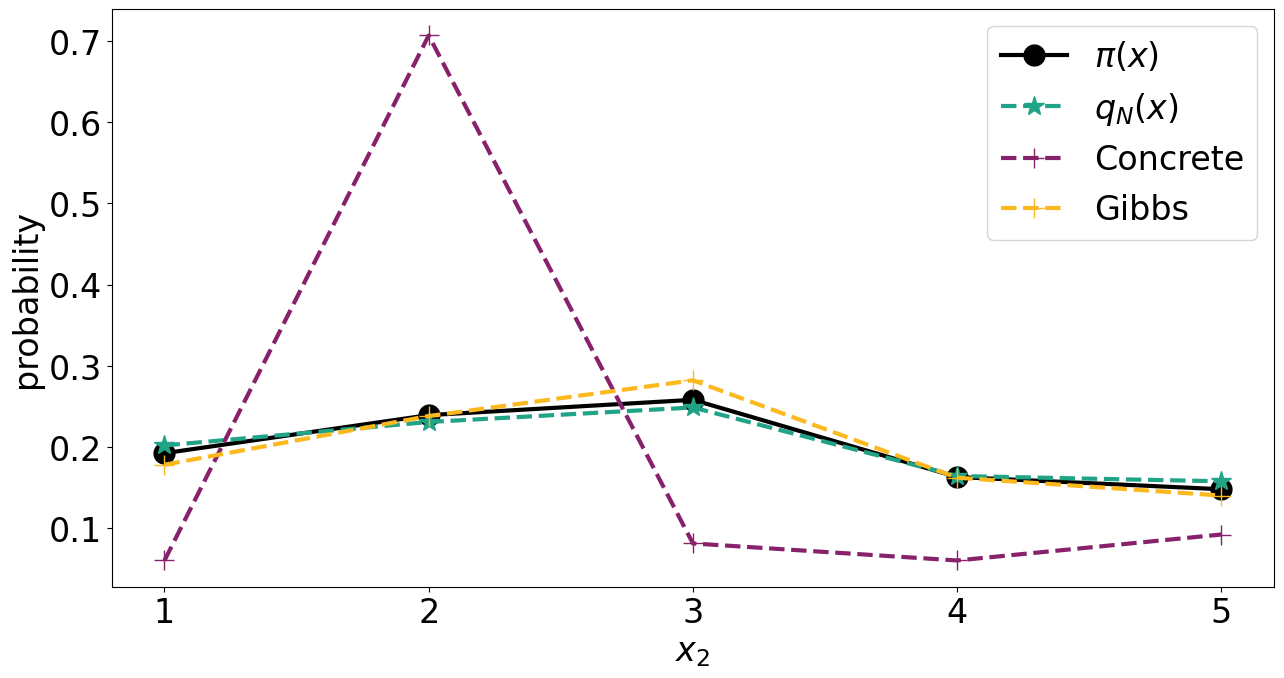

In [547]:
########################
########################
#   plot x2 results    #
########################
########################

ttx=np.arange(0,K2)
plt.plot(ttx+0.5,np.sum(prbs,axis=0),c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.plot(ttx+0.5,np.sum(myqvar,axis=0),c='#20A386FF', label=r'$q_N(x)$',lw=3,ls='dashed',ms=15,marker='*')
plt.plot(ttx+0.5,np.sum(densities2d[np.argmax(elbos2d),:,:],axis=0),c='#87216BFF', label='Concrete',lw=3,ls='dashed',ms=15,marker='+')
#plt.hist(gibbs_samples[1,:],density=True,bins=np.arange(0,K2+1),alpha=0.35, label='Gibbs', color="#FBB91FFF",ec='black')
plt.plot(ttx+0.5,np.sum(gibbs_density,axis=0),c='#FBB91FFF', label='Gibbs',lw=3,ls='dashed',ms=15,marker='+')
plt.legend()
plt.xlabel(r'$x_2$')
plt.xticks(ticks=np.arange(0,K2)+0.5,labels=np.arange(1,1+K2))
plt.ylabel('probability')

## Bimodal example

We finally consider a 2D bimodal example.
Specifically,
let $X_2|X_1=x$ be a discretized Gaussian on $\{1,\dots,20\}$ 
with mean $\mu_x$ and unit variance,
where $X_1\sim\mathsf{Unif}\{0,1\}$ and $\mu_0=4,\mu_1=15$.
Hence $\mathbb{P}(X_2=n\,|\,X_1=x)\propto\phi(n-\mu_x)$, $n\in[20], x=0,1$,
where $\phi$ is the pdf of a standard Gaussian.

A standard Gibbs sampler initialized at the first mode will get stuck:
moving only along $x_2$ is a highly unlikely proposal since
it corresponds to the probability of observing a tail value under the second mode.
An analogous argument applies to a sampler initialized at the second mode.

In the case of Mad Mix, we can leverage the fact that we can estimate the ELBO
to optimally weight two different flows, each initialized in a different mode.
That is, we consider a variational proposal of the form
$$
    q_N=wq_{N,0}+(1-w)q_{N,1},
$$
where $w\in(0,1)$ and $q_{N,i}=\frac{1}{N}\sum_{n=0}^{N-1} T^n q_i$
and $q_i$ is a distribution that covers mode $i$, $i=0,1$.
We then select
$$
    w=\arg\min_{\alpha\in(0,1)}
    \mathrm{D}_{\mathrm{KL}}
    (\alpha q_{N,0}+(1-\alpha)q_{N,1}\,||\,\pi),
$$
which can be estimated via gradient descent since
$$
    \frac{\mathrm{d}}{\mathrm{d}\alpha}
    \alpha q_{N,0}+(1-\alpha)q_{N,1}
    =\mathbb{E}_{q_{N,0}}
    \left[\log\frac{\alpha q_{N,0}+(1-\alpha)q_{N,1}}{\pi}\right]
    -\mathbb{E}_{q_{N,1}}
    \left[\log\frac{\alpha q_{N,0}+(1-\alpha)q_{N,1}}{\pi}\right].
$$

Below we run Gibbs sampler for 50,000 iterations (saving only the last 500)
and then show the density of each $q_{N,i}$.
Then we optimize $w$ and compare the density of $q_N$
with the results from the Gibbs sampler.

In [467]:
########################
########################
# target specification #
########################
########################
eps=1e-16
mu=np.array([4,15]) # the two modes
K1,K2=20,2
def aux_gausslp(aux): return -0.5*(np.arange(0,20)-mu[aux][:,np.newaxis])**2-0.5*np.log(2*np.pi)
def aux_gausslp_1d(y,x): return -0.5*(y-mu[x])**2-0.5*np.log(2*np.pi)

def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs
    #
    # inputs:
    #    x    : (2,d) array with state values
    #    axis : int, full conditional to calculate; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,K_{axis+1}) array with d conditionals 
    
    y=x[0,:]
    aux=x[1,:]
    
    if axis==None: return -0.5*(y-mu[aux])**2-0.5*np.log(2*np.pi)#1.
    if axis==0: return aux_gausslp(aux)
    if axis==1: 
        wlpy0=aux_gausslp_1d(y,0)+np.log(0.5)
        wlpy1=aux_gausslp_1d(y,1)+np.log(0.5)
        m=np.maximum(wlpy0,wlpy1)
        lpy=m+np.log(np.exp(wlpy0-m)+np.exp(wlpy1-m))
        #out=np.log1p(-eps)*np.ones((y.shape[0],2))
        #out[y>=10,0]=np.log(eps)
        #out[y<10,1]=np.log(eps)
        #out=0.5*np.ones((y.shape[0],2))
        out=np.ones((y.shape[0],2))
        out[:,0]=wlpy0
        out[:,1]=wlpy1
        return out-lpy[:,np.newaxis]
    raise Exception("Axis out of bounds - there aren't that many variables")

In [468]:
# evaluate target density
x=np.zeros((2,40),dtype=int)
x[0,:20]=np.arange(0,20)
x[0,20:]=np.arange(0,20)
x[1,20:]=np.ones(20,dtype=int)

mylp=np.exp(lp(x))
prbs=np.zeros((20,2))
prbs[:,0]=mylp[:20]
prbs[:,1]=mylp[20:]
prbs=prbs/np.sum(prbs)

In [469]:
########################
########################
#    MAD Mix approx    #
########################
########################

# reference specification
def lq0_0(x,u):
    out=-0.5*(x[0,:]-mu[0])**2-0.5*np.log(2*np.pi)
    out[x[1,:]==0]=np.log(1e-32)
    return out
def lq0_1(x,u):
    out=-0.5*(x[0,:]-mu[1])**2-0.5*np.log(2*np.pi)
    out[x[1,:]==1]=np.log(1e-32)
    return out

N=100 # number of steps in qN
xi=np.pi/16

# evaluate density
x=np.zeros((2,40),dtype=int)
x[0,:20]=np.arange(0,20)
x[0,20:]=np.arange(0,20)
x[1,20:]=np.ones(20,dtype=int)
#myx=np.copy(x)
u=np.random.rand(2,40)

# mode 1
qvar0=np.exp(lqN(x,u,N,lq0_0,lp,xi))
myqvar0=np.zeros((20,2))
myqvar0[:,0]=qvar0[:20]
myqvar0[:,1]=qvar0[20:]

# mode 2
#u=np.random.rand(2,40)
qvar1=np.exp(lqN(x,u,N,lq0_1,lp,xi))
myqvar1=np.zeros((20,2))
myqvar1[:,0]=qvar1[:20]
myqvar1[:,1]=qvar1[20:]

In [470]:
########################
########################
#    Gibbs sampling    #
########################
########################
N=500
x0=np.array([15,1])
gibbs_samples=gibbs_sampler(x0=x0,steps=N,lp=lp,burnin_pct=0.99,verbose=True)

In [471]:
# get density and compute ELBO
gibbs_density=plt.hist2d(gibbs_samples[0,:],gibbs_samples[1,:],density=True,
                         bins=[np.arange(0,21),np.arange(0,3)])[0]
plt.clf()
gibbs_density[gibbs_density<1e-32]=1e-32
elbo_gibbs=elbo_exact(np.log(gibbs_density),np.log(prbs))

<Figure size 1500x750 with 0 Axes>

Text(0, 0.5, 'probability')

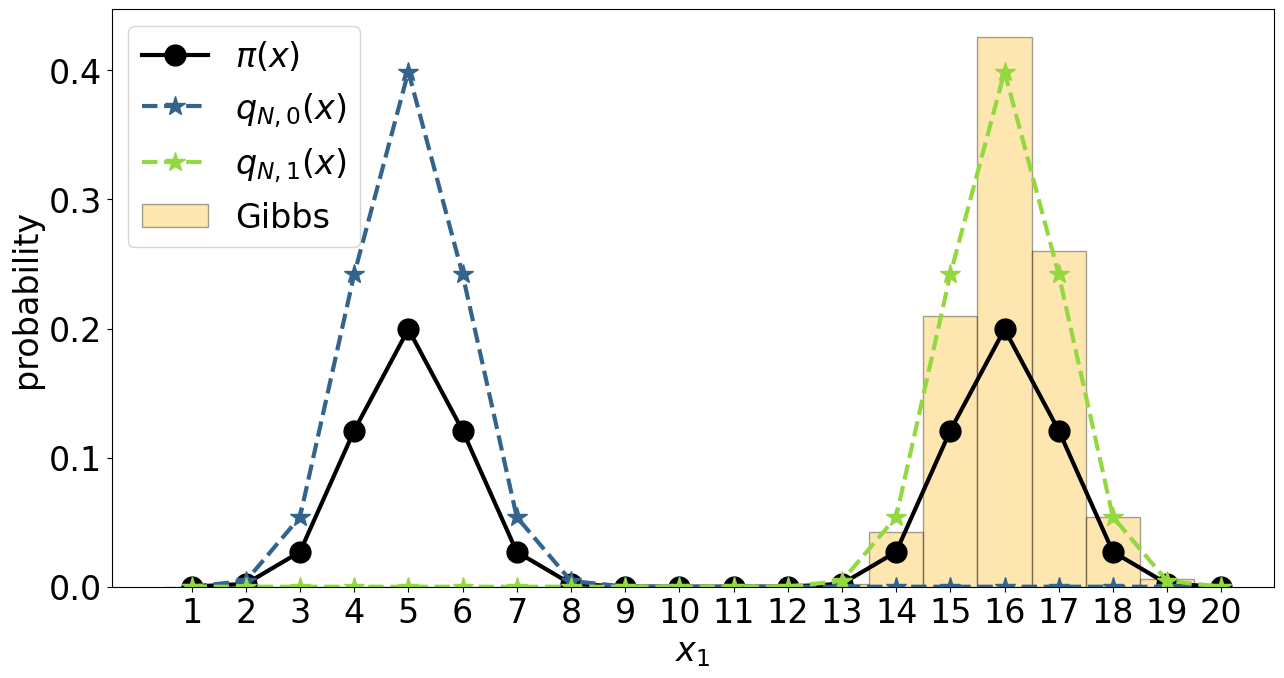

In [472]:
ttx=np.arange(0,20)
plt.plot(ttx+0.5,np.sum(prbs/np.sum(prbs),axis=1),c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.plot(ttx+0.5,np.sum(myqvar0/np.sum(myqvar0),axis=1),c='#32648EFF', label=r'$q_{N,0}(x)$',lw=3,ls='dashed',ms=15,marker='*')
plt.plot(ttx+0.5,np.sum(myqvar1/np.sum(myqvar1),axis=1),c='#94D840FF', label=r'$q_{N,1}(x)$',lw=3,ls='dashed',ms=15,marker='*')
plt.hist(gibbs_samples[0,:],density=True,bins=np.arange(0,20),
         alpha=0.35, label='Gibbs', color="#FBB91FFF",ec='black')
plt.legend()
plt.xlabel(r'$x_1$')
plt.xticks(ticks=np.arange(0,20)+0.5,labels=np.arange(1,21))
plt.ylabel('probability')

### KL-optimal weighting

In [473]:
###############################
###############################
# variational family settings #
###############################
###############################

N=100 # number of steps in qN
xi=np.pi/16
lq0 = lambda x : lqN(x,np.random.rand(2,40),N,lq0_0,lp,xi)
lq1 = lambda x : lqN(x,np.random.rand(2,40),N,lq0_1,lp,xi)
def lq(x,w):
    exp1=lq0(x)+np.log(w)
    exp2=lq1(x)+np.log1p(-w)
    m=np.maximum(exp1,exp2)
    return m+np.log(np.exp(exp1-m)+np.exp(exp2-m))



# init x grid and fixed densities
x=np.zeros((2,40),dtype=int)
x[0,:20]=np.arange(0,20)
x[0,20:]=np.arange(0,20)
x[1,20:]=np.ones(20,dtype=int)
lq0_fixed=lq0(x)
lq1_fixed=lq1(x)
def lq_fixed(w):
    exp1=lq0_fixed+np.log(w)
    exp2=lq1_fixed+np.log1p(-w)
    m=np.maximum(exp1,exp2)
    return m+np.log(np.exp(exp1-m)+np.exp(exp2-m))
full_lp=lp(x)

In [474]:
######################
######################
#    optimization    #
######################
######################

# optimization settings
np.random.seed(2023)
max_iter=10001
gamma=1e1
w=np.random.rand()
print('Initial w: '+str(w))
print()
print('Iter  |          w          |   gradient')

for t in range(max_iter):
    #print(str(t+1)+'/'+str(max_iter),end='\r')
    #gradient=np.sum((np.exp(lq0_fixed)-np.exp(lq1_fixed))*(lq(x,w)-lp(x))) # unfixed x
    gradient=np.sum((np.exp(lq0_fixed)-np.exp(lq1_fixed))*(lq_fixed(w)-full_lp)) # with fixed x
    w=w-gradient*gamma/np.sqrt(t+1)
    w=min(1-1e-16,max(1e-16,w)) # constrain to (0,1)
    if t%(max_iter//10)==0: print('  '+str(t+1)+'   | '+str(w)+'  | '+str(gradient))
# end for

Initial w: 0.32198830399196776

Iter  |          w          |   gradient
  1   | 0.3964531248953041  | -0.007446482090333634
  1001   | 0.49999999999896017  | -6.439293542825908e-14
  2001   | 0.5000000000005429  | -1.6653345369377348e-16
  3001   | 0.5000000000005429  | -1.6653345369377348e-16
  4001   | 0.5000000000005429  | -1.6653345369377348e-16
  5001   | 0.5000000000005429  | -1.6653345369377348e-16
  6001   | 0.5000000000005429  | -1.6653345369377348e-16
  7001   | 0.5000000000005429  | -1.6653345369377348e-16
  8001   | 0.5000000000005429  | -1.6653345369377348e-16
  9001   | 0.5000000000005429  | -1.6653345369377348e-16
  10001   | 0.5000000000005429  | -1.6653345369377348e-16


In [475]:
weighted_q=np.exp(lq(x,w))
myqvar=np.zeros((20,2))
myqvar[:,0]=weighted_q[20:]
myqvar[:,1]=weighted_q[:20]

In [477]:
########################
########################
#    Concrete          #
########################
########################
from IPython.display import clear_output
RUN=False # ONLY TRUE IF YOU WANT TO RERUN RESULTS

# TIME SUNK!!! RUN AT YOUR OWN PERIL
# simulation settings:
max_iters = 10001
temps     = np.array([0.1,0.5,1,5])
depths    = np.array([10,50,100])
layers    = np.array([32,64,128,256])
sim_size  = temps.shape[0]*depths.shape[0]*layers.shape[0]
if RUN:
    # redefine arrays only if running from scratch
    flowsmix     = [0 for i in range(sim_size)]
    lossesmix    = np.zeros((sim_size,max_iters))
    cpu_timesmix = np.zeros(sim_size)

i=0
print('Training '+str(sim_size)+' flows')
for temp in temps:
    if not RUN: continue
    for depth in depths:
        for width in layers:
            print('Training flow '+str(i+1)+'/'+str(sim_size))
            print('Temperature: '+str(temp))
            print('Depth: '+str(depth))
            print('Width: '+str(width))
            t0 = time.perf_counter()
            tmp_flow,tmp_loss=trainRealNVP(
                temp=temp,depth=depth,lprbs=np.log(prbs).flatten(),layers=layer,max_iters=max_iters,lr=1e-3,seed=2023
            )
            cpu_timesmix[i]=time.perf_counter()-t0
            flowsmix[i]=tmp_flow
            lossesmix[i,:]=tmp_loss
            clear_output(wait=True)
            i=i+1
        # end for
    # end for
# end for
clear_output(wait=True)
print('Done!')
print('Total training time: '+str(cpu_timesmix.sum())+' seconds')

Done!
Total training time: 35320.28236866827 seconds


Text(0.5, 1.0, 'Concrete RealNVP training loss traceplots')

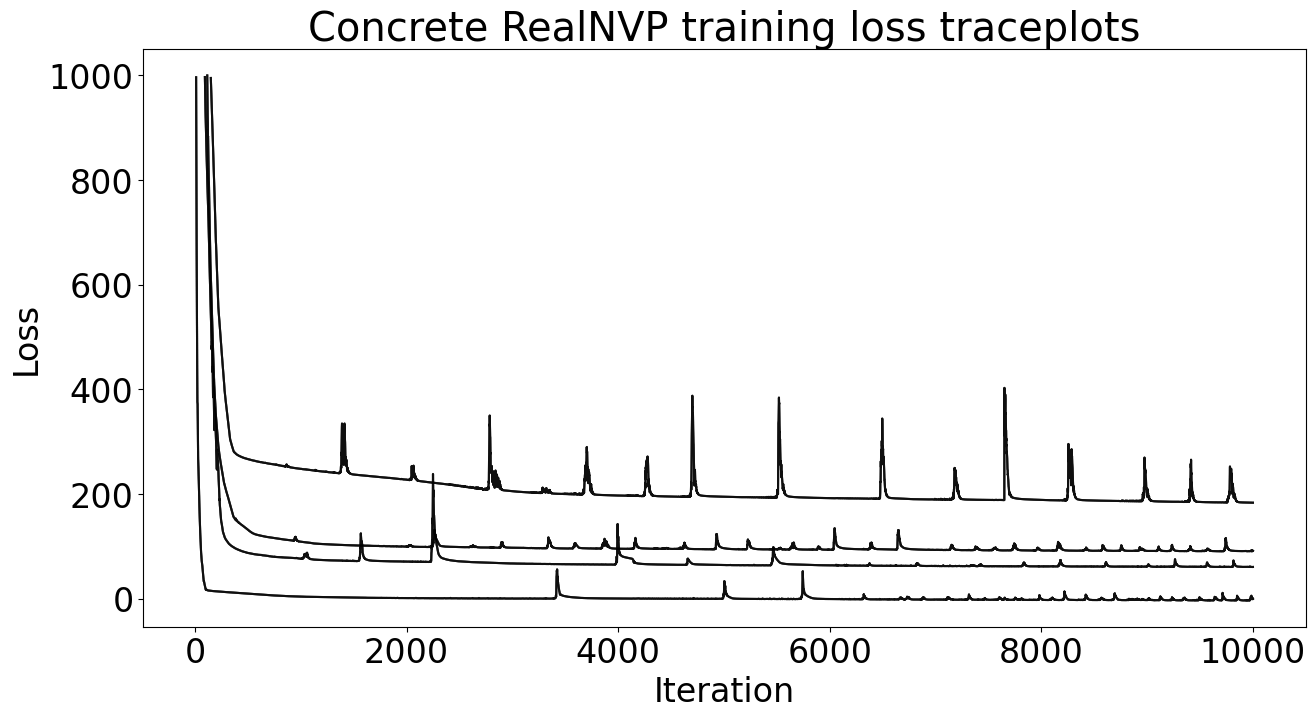

In [478]:
# loss traceplot
threshold=1000
for i in range(sim_size): plt.plot(np.arange(max_iters)[lossesmix[i,:]<threshold],lossesmix[i,lossesmix[i,:]<threshold],'-k',alpha=0.5)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Concrete RealNVP training loss traceplots')

In [526]:
#########################
#########################
# get samples and elbos #
#########################
#########################
torch.manual_seed(0)
sample_size=1000
samplesmix=np.zeros((sim_size,2,sample_size))
densitiesmix=np.zeros((sim_size,K1,K2))
elbosmix=np.zeros(sim_size)

for i in range(sim_size):
    print(str(i+1)+'/'+str(sim_size),end='\r')
    tmp_flow=flowsmix[i]
    
    # generate sample
    tmp_sample=tmp_flow.sample(sample_size)
    tmp_sample=np.exp(np.squeeze(tmp_sample.detach().numpy())) # expConcrete->Concrete
    tmp_sample=tmp_sample/np.sum(tmp_sample,axis=-1)[:,np.newaxis] # normalize probs
    tmp_sample=np.argmax(tmp_sample,axis=-1) # rounding Concrete
    tmp_sample=idx_unflatten(tmp_sample,K2) # 1d->2d
    samplesmix[i,:,:]=tmp_sample
    
    # compute freq density
    tmp_density=plt.hist2d(tmp_sample[0,:],tmp_sample[1,:],density=True,
                         bins=[np.arange(0,21),np.arange(0,3)])[0]
    tmp_density[tmp_density<1e-32]=1e-32 # to avoid underflow when taking log
    densitiesmix[i,:,:]=tmp_density
    
    # estimate elbo
    elbosmix[i]=elbo_exact(np.log(tmp_density),np.log(prbs))
# end for
plt.clf()

/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_73986/4100564542.py:18: RuntimeWarning: overflow encountered in exp
  tmp_sample=np.exp(np.squeeze(tmp_sample.detach().numpy())) # expConcrete->Concrete
/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_73986/4100564542.py:19: RuntimeWarning: invalid value encountered in divide
  tmp_sample=tmp_sample/np.sum(tmp_sample,axis=-1)[:,np.newaxis] # normalize probs


<Figure size 1500x750 with 0 Axes>

In [527]:
i_starmix=np.argmax(elbosmix) #
print('Optimal flow: '+str(i_starmix))

Optimal flow: 36


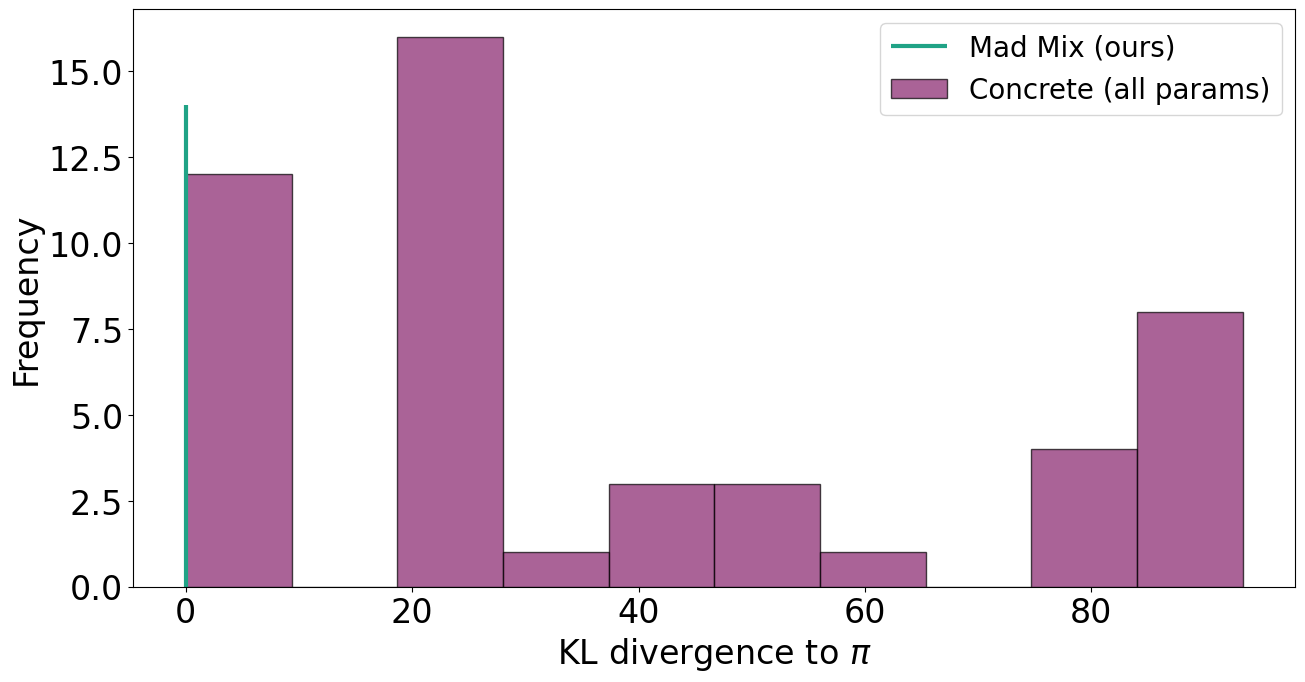

In [528]:
plt.vlines(-elbo_qN,ymin=0,ymax=14,colors='#20A386FF',lw=3,label='Mad Mix (ours)')
#plt.vlines(-elbo_gibbs,ymin=0,ymax=20,colors='#FBB91FFF',lw=1.5,label='Gibbs',alpha=0.8)
plt.hist(-elbosmix,bins=15,color='#87216BFF',ec='black',alpha=0.7,label='Concrete (all params)') #taking out elbo<-2
plt.xlabel(r'KL divergence to $\pi$')
plt.ylabel('Frequency')
plt.legend(fontsize='small')

Text(0, 0.5, 'probability')

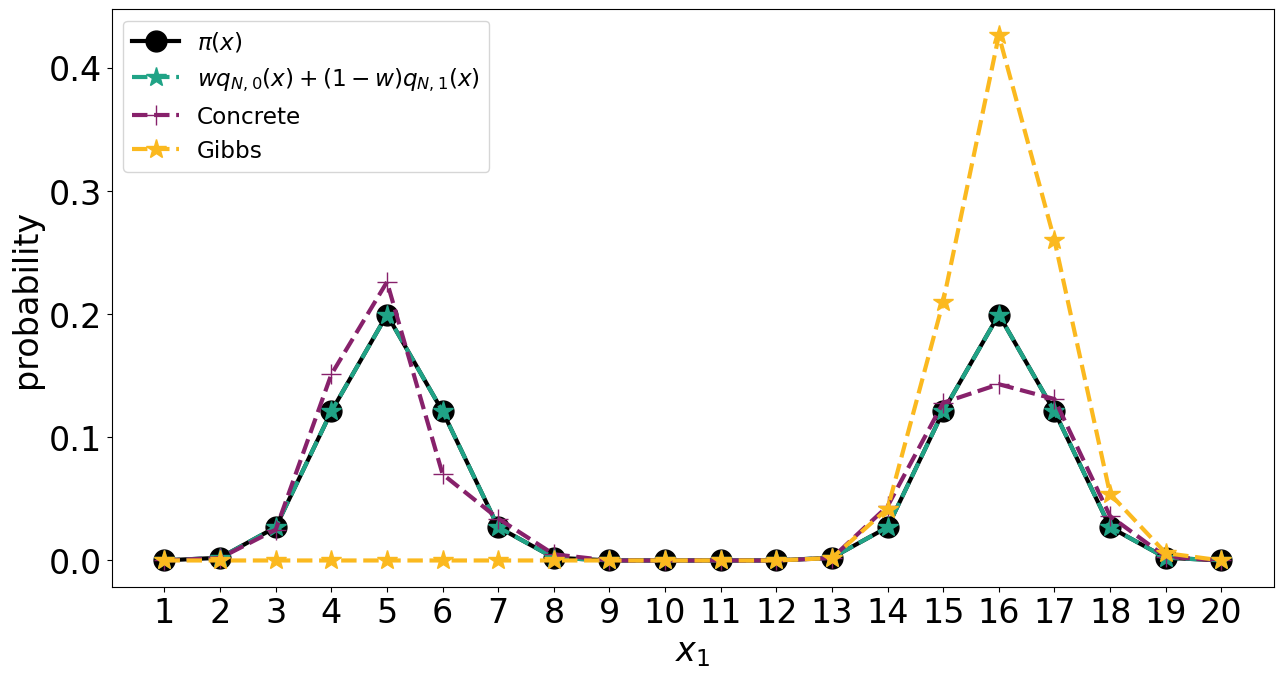

In [533]:
ttx=np.arange(0,20)
plt.plot(ttx+0.5,np.sum(prbs/np.sum(prbs),axis=1),c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.plot(ttx+0.5,np.sum(myqvar/np.sum(myqvar),axis=1),c='#20A386FF', 
         label=r'$wq_{N,0}(x)+(1-w)q_{N,1}(x)$',lw=3,ls='dashed',ms=15,marker='*')
plt.plot(ttx+0.5,np.sum(densitiesmix[np.argmax(elbosmix),:,:],axis=1),
         c='#87216BFF', label='Concrete',lw=3,ls='dashed',ms=15,marker='+')
plt.plot(ttx+0.5,np.sum(gibbs_density/np.sum(gibbs_density),axis=1),c='#FBB91FFF', 
         label=r'Gibbs',lw=3,ls='dashed',ms=15,marker='*')
plt.legend(fontsize='x-small')
plt.xlabel(r'$x_1$')
plt.xticks(ticks=np.arange(0,20)+0.5,labels=np.arange(1,21))
plt.ylabel('probability')

In [531]:
# optimal weight density
opt_weighted_q=np.exp(lq(x,0.5))
wstar_qvar=np.zeros((20,2))
wstar_qvar[:,0]=opt_weighted_q[20:]
wstar_qvar[:,1]=opt_weighted_q[:20]

In [532]:
elbo_qstar=elbo_exact(np.log(wstar_qvar/np.sum(wstar_qvar)),np.log(prbs))
elbo_qN=elbo_exact(np.log(myqvar/np.sum(myqvar)),np.log(prbs))
elbo_gibbs=elbo_exact(np.log(gibbs_density),np.log(prbs))
print('ELBO(q*||π)='+str(elbo_qstar))
print('ELBO(qN||π)='+str(elbo_qN))
print('ELBO(qGibbs||π)='+str(elbo_gibbs))
print('ELBO(qConcrete_opt||π)='+str(elbosmix[np.argmax(elbosmix)]))

ELBO(q*||π)=-1.689238930571031e-11
ELBO(qN||π)=-1.5349521180881244e-11
ELBO(qGibbs||π)=-0.6997140280117313
ELBO(qConcrete_opt||π)=-0.03576607899957991
